# 사전 학습된 모델 준비

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision.models.resnet import resnet18


model = resnet18(pretrained=True) # vgg16 모델  객체 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_output = 10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_output)
model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 284MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 입력 채널 수 x 필터 크기 x 출력 채널 수
- 입력 : ( 3 ,224 ,224 ) [ C, H, W ]
  - Conv2d-1         [-1, 64, 112, 112]      ->     9,408
    - 3x49x64 = 9408 (Conv2d-1은 bias를 사용하지 않으므로 출력 채널 수만큼 bias 파라미터가 추가로 필요하지 않습니다.)
  - BatchNorm2d-2         [-1, 64, 112, 112]      ->       128
    - BatchNorm2d-2는 64개의 출력 채널에 대해 스케일 및 이동 파라미터를 가지며, 각 파라미터는 스칼라이므로 64x2

In [2]:
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# 데이터 전처리와 증강

In [3]:
import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
   Resize(224), #인자가 하나: 이미지작은쪽의 크기를 224의 크기로 맞춤
   RandomCrop((224, 224), padding=4),
   RandomHorizontalFlip(p=0.5),
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 데이터로더 정의

In [4]:
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29368068.15it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


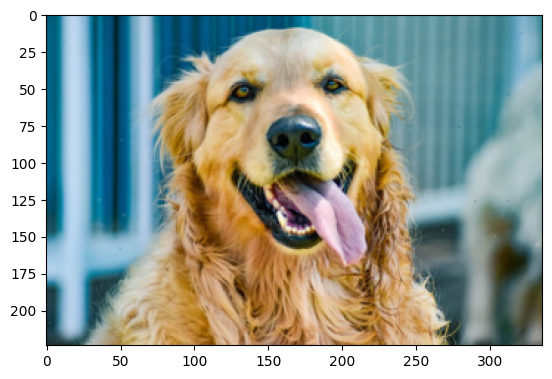

tensor구조일 떄: torch.Size([3, 224, 224])
변경됨!(Numpy일 때!): (224, 224, 3)


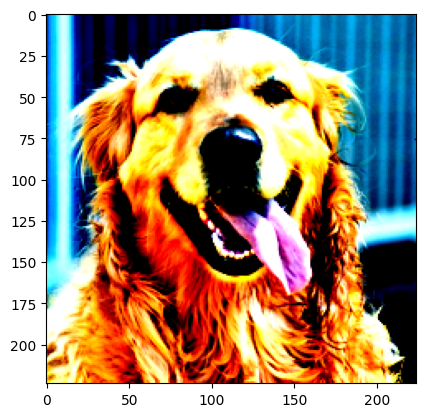

In [7]:
#특정 크기로 크기를 조정하고 정규화를 적용하고 텐서 형식으로 변환하여 딥 러닝 모델에 입력할 이미지를 준비

import numpy as np
import json
from torchvision.transforms import Normalize, CenterCrop,ToPILImage
from PIL import Image
import matplotlib.pyplot as plt


resize = 224
testImage_transforms = Compose([
   Resize(224),#크기조정
   CenterCrop(224),#중심축의 기준으로 224?
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))#가우스분포로 정규화
])

image_file_path = '/content/drive/MyDrive/Colab Notebooks/ws_colab/colab_workspace/SSU/DL/8w/testImg/goldenretriever.jpg'
testPILimg = Image.open(image_file_path)
resize = Resize(224)
testPILimg = resize(testPILimg)
plt.imshow(testPILimg)
plt.show()

testImgTensor_transformed = testImage_transforms(testPILimg)  # torch.Size([3, 224, 224])
print('tensor구조일 떄:',testImgTensor_transformed.shape)

#toPIL = ToPILImage()
#testImg_transformed = toPIL(testImgTensor_transformed)

testImgNumpy_transformed = testImgTensor_transformed.numpy().transpose((1, 2, 0)) #칼라 이미지 : [3(채널),224(H),224(W)] -> 넘파이:[H,W,C] = [224,224,3] (따라서 (1,2,0)을 쓴다. 채널이 뒤로와서.)
print('변경됨!(Numpy일 때!):',testImgNumpy_transformed.shape)
#print(testImgNumpy_transformed)
testImg_transformed = np.clip(testImgNumpy_transformed, 0, 1) #clipping 수행! 이미지 배열의 픽셀 값이 0과 1 사이로 조정, 초과값은 이와 가까운 값으로 조정
#print(testImg_transformed)
plt.imshow(testImgNumpy_transformed)
plt.show()

- 에러? : WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  - 0보다 작은값에 대해 0으로 Clipping함.
  - clipping시켜서 학습 시키면 안된다.

  - clipping 전
  
  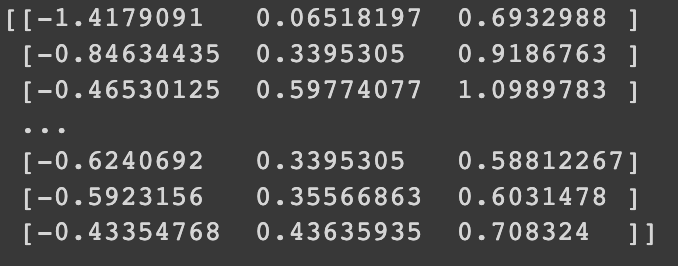

  - clipping 후

  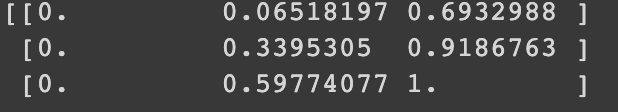
  

In [8]:
params_name_to_update = ['fc.weight'] #가중치 'fc.weight'의 이름만 포함된 'params_name_to_update' 목록에 있는지 확인
params_to_update = []
for name, param in model.named_parameters():
    if name in params_name_to_update:
        param.requirs_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
params_to_update

[Parameter containing:
 tensor([[-2.7271e-02, -2.6488e-02, -1.3550e-02,  ..., -2.1023e-02,
           2.0472e-02,  3.1074e-02],
         [-7.5274e-03,  2.6369e-02, -4.0964e-02,  ..., -7.1412e-03,
           2.1192e-02,  7.9450e-03],
         [ 6.6772e-03, -6.8209e-03, -4.8069e-03,  ..., -8.0995e-03,
          -2.4792e-02, -1.0442e-02],
         ...,
         [ 4.4082e-02,  7.9757e-04,  1.5607e-03,  ..., -1.9283e-02,
           2.3935e-02,  9.5373e-05],
         [ 1.7876e-02,  4.2611e-02,  3.3770e-02,  ..., -9.0975e-03,
          -3.0684e-02, -2.3618e-02],
         [ 2.2962e-02,  3.8650e-02,  1.8012e-02,  ..., -1.4812e-03,
           6.9891e-03, -3.6243e-02]], device='cuda:0', requires_grad=True)]

# 학습 루프 정의

In [9]:
lr = 1e-4
#optim = Adam(model.parameters(), lr=lr)
optim = Adam(params=params_to_update, lr=lr)
for epoch in range(5):
   iterator = tqdm.tqdm(train_loader) # ➊ 학습 로그 출력
   for data, label in iterator:
       optim.zero_grad()

       preds = model(data.to(device)) # 모델의 예측값 출력

       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()
     
       # ❷ tqdm이 출력할 문자열
       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained_ResNet.pth") # 모델 저장

epoch:5 loss:0.5607678890228271: 100%|██████████| 1563/1563 [02:41<00:00,  9.67it/s]


### 정확도 출력

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained_ResNet.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       _, preds = output.data.max(1)
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

- 입력 : [B(배치사이즈), C(채널), H, W]
  - [1,3,224,224] -> squeeze(0) -> [3,224,224]
  - [3,224,224] -> unsqueeze(0) -> [1,3,224,224] (torch에서 입력으로 받는 구조)

In [ ]:
testimg = testImgTensor_transformed.unsqueeze(0)
print(testimg)
output = model(testimg.to(device))
_, pred = output.data.max(1)
print(pred.shape)
obj_class = cifar10_classes[pred]
print(obj_class)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
